In [2]:
import matplotlib.pyplot as plt
import numpy as np
from util import *
import cv2 as cv

# This script uses example data. You will have to modify the
# loading code below to suit how you structure your data.

#MY CODE:
K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.

I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage

 
# Initiate SIFT detector
sift = cv.SIFT_create()

#SIFT ONLY TAKES 8-bit images - so converting here:
I1 = cv.normalize(I1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')



# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(I1,None)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from util import *
import cv2 as cv

K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.

I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage

surf = cv.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(I1,None)

In [26]:
print(des[2,:])

[-1.45614240e-03 -9.68632521e-04  3.07481433e-03  1.33426476e-03
  2.28246837e-03 -3.42615251e-03  5.80050610e-02  7.42705632e-03
  1.30623262e-02 -3.16213770e-03  3.90657336e-02  1.19081745e-02
 -1.93170912e-03 -7.35913578e-04  2.53592175e-03  2.27061240e-03
 -6.92608347e-03  1.63494004e-03  2.30333004e-02  3.49352905e-03
  1.78307354e-01  6.81513846e-02  4.14283693e-01  1.04070023e-01
 -3.82617079e-02  2.69451082e-01  2.49372736e-01  2.80877739e-01
 -1.28978956e-02  4.95282188e-03  1.94427073e-02  1.55423274e-02
 -8.42521805e-03  6.85818493e-03  1.99280940e-02  8.47476162e-03
  2.03683421e-01 -8.04084241e-02  4.20143664e-01  1.16812304e-01
 -6.41592592e-02 -3.17241669e-01  2.91290820e-01  3.50206673e-01
 -2.46271584e-02  5.34082064e-03  3.64275947e-02  6.14725566e-03
 -1.21018523e-03 -1.94791041e-03  2.78114527e-03  2.06650374e-03
  3.12756114e-02 -6.54510455e-03  4.42953594e-02  9.77594126e-03
 -1.01831397e-02  5.10990387e-04  5.35833091e-02  5.83754899e-03
 -8.04310385e-03 -2.92756

In [5]:
K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.

I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage

sift = cv.xfeatures2d.SIFT_create()
surf = cv.xfeatures2d.SURF_create(400)

features = sift.detect(I1)

kp ,des = sift.compute(I1,features)
# Find keypoints and descriptors directly

(array([99., 10.,  8.,  2.,  2.,  1.,  0.,  0.,  0.,  6.]),
 array([  0. ,  18.4,  36.8,  55.2,  73.6,  92. , 110.4, 128.8, 147.2,
        165.6, 184. ], dtype=float32),
 <a list of 10 Patch objects>)

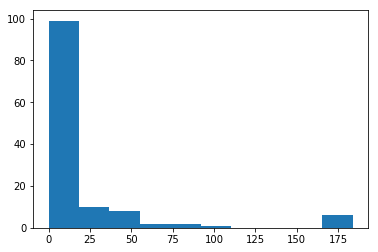

In [10]:
plt.hist(des[0,:])

In [3]:
 import pymagsac



ModuleNotFoundError: No module named 'pymagsac'

In [2]:
 print(cv.USAC_MAGSAC)

#cv.LMEDS - least-median of squares algorithm
#cv.RANSAC - Ransac algorithm
#cv.RHO - RHO algorithm
#cv.USAC_DEFAULT -  USAC algorithm, default settings.
#cv.USAC_PROSAC -  USAC, sorted points, runs PROSAC. #TRY THIS IN ESSENTIAL MATRIX FINDING
#cv.USAC_ACCURATE / FAST, etc...
#cv.USAC_MAGSAC - Runs MAGSAC++



AttributeError: module 'cv2' has no attribute 'USAC_MAGSAC'

In [1]:
#TESTING OPENCV RANSACS:

import matplotlib.pyplot as plt
import numpy as np
from util import *
from triangulate_many import *
from estimate_E_ransac import *
from decompose_E import *
import cv2 as cv

#TODO: 
#ESTIMATE CAMERA POSE BY 
#1.PnP solver inside RANSAC
#2.Nonlinear refinement that minimizes reprojection error


K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.
I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage
I2 = cv.imread("../visualization_sample_data/query/IMG_8210.jpg", cv.IMREAD_GRAYSCALE) #trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

#SIFT ONLY TAKES 8-bit images - so converting here:
I1 = cv.normalize(I1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
I2 = cv.normalize(I2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(I1,None)
kp2, des2 = sift.detectAndCompute(I2,None)

# BFMatching of the descriptors/features
bf = cv.BFMatcher()
matches = bf.match(des1,des2)


#Pixel coordinates/point correspondences extracted:
uv1 = np.array([kp1[mat.queryIdx].pt for mat in matches]).T
uv2 = np.array([kp2[mat.trainIdx].pt for mat in matches]).T


uv1_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))
uv2_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))

 
xy1 = np.linalg.inv(K)@uv1_tilde
xy2 = np.linalg.inv(K)@uv2_tilde


#Ransac without PnP: - WORKS:
num_trials = get_num_ransac_trials(8, confidence=0.99, inlier_fraction=0.5)
E1,inliers = estimate_E_ransac(xy1, xy2, K, distance_threshold=4, num_trials=num_trials)

Running RANSAC with 4 inlier threshold and 1176 trials...Done!
Found solution with 28919/28919 inliers


In [2]:

uv1 = uv1.reshape(-1,1,2)
uv2 = uv2.reshape(-1,1,2)
E_r,inliers = cv.findEssentialMat(uv1,uv2,K,method=cv.RANSAC,threshold=4)
E_lmeds,inliers = cv.findEssentialMat(uv1,uv2,K,method=cv.LMEDS,threshold=4)
E_rho,inliers = cv.findEssentialMat(uv1,uv2,K,method=cv.RHO,threshold=4)




#cv.LMEDS - least-median of squares algorithm
#cv.RANSAC - Ransac algorithm
#cv.RHO - RHO algorithm
#cv.USAC_DEFAULT -  USAC algorithm, default settings.
#cv.USAC_PROSAC -  USAC, sorted points, runs PROSAC. #TRY THIS IN ESSENTIAL MATRIX FINDING
#cv.USAC_ACCURATE / FAST, etc...
#cv.USAC_MAGSAC - Runs MAGSAC++



error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\calib3d\src\usac\essential_solver.cpp:197: error: (-213:The function/feature is not implemented) To use essential matrix solver LAPACK or Eigen has to be installed! in function 'cv::usac::EssentialMinimalSolverStewenius5ptsImpl::estimate'


In [ ]:
print(E1)
print(E)
print(E_lmeds)
print(E_magsac)

In [15]:
F_loransac,inliers_loransac = cv.findFundamentalMat(uv1,uv2,cv.USAC_DEFAULT) #Default LO-RANSAC
F_lopr,inliers_lopr = cv.findFundamentalMat(uv1,uv2,cv.USAC_PARALLEL)        #LO-RANSAC + RANSAC
F_prosac,inliers_prosac = cv.findFundamentalMat(uv1,uv2,cv.USAC_PROSAC)      #Prosac
F_gcransac,inliers_gcransac = cv.findFundamentalMat(uv1,uv2,cv.USAC_ACCURATE)#GC-RANSAC
F_magsac,inliers_magsac = cv.findFundamentalMat(uv1,uv2,cv.USAC_MAGSAC)      #MAGSAC++

#cv.RANSAC - Ransac algorithm
#cv.LMEDS - least-median of squares algorithm
#cv.RHO - RHO algorithm
#USAC_DEFAULT – has standard LO-RANSAC.
#USAC_PARALLEL – has LO-RANSAC and RANSACs run in parallel.
#USAC_ACCURATE – has GC-RANSAC.
#USAC_FAST – has LO-RANSAC with smaller number iterations in local optimization step. Uses RANSAC score to maximize number of inliers and terminate earlier.
#USAC_PROSAC – has PROSAC sampling. Note, points must be sorted. <- NOTE POINTS MUST BE SORTED
#USAC_FM_8PTS – has LO-RANSAC. Only valid for Fundamental matrix with 8-points solver.
#USAC_MAGSAC – has MAGSAC++. 

#TODO FIND E FROM F:
#E= K.T@F@K